# Setup

In [9]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import mlflow
import dagshub

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

dagshub.init(repo_owner='TomC333', repo_name='ml-walmart-recruiting', mlflow=True)
mlflow.set_experiment("RandomForest_Training")

train = pd.read_csv("data/train_merged.csv", parse_dates=["Date"])
test = pd.read_csv("data/test_merged.csv", parse_dates=["Date"])

Initialized MLflow to track repo "TomC333/ml-walmart-recruiting"

Repository TomC333/ml-walmart-recruiting initialized!

# Feature Engineering

In [10]:
def create_rf_enhanced_features(df):
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df["DayOfWeek"] = df["Date"].dt.weekday
    df["Week"] = df["Date"].dt.isocalendar().week.astype(int)
    df["Quarter"] = df["Date"].dt.quarter

    df["IsHoliday"] = df["IsHoliday"].astype(int)

    df["IsBeforeHoliday"] = df["IsHoliday"].shift(-1, fill_value=0)

    df["IsMonthStart"] = df["Date"].dt.is_month_start.astype(int)
    df["IsMonthEnd"] = df["Date"].dt.is_month_end.astype(int)

    df["IsWeekend"] = df["DayOfWeek"].isin([5, 6]).astype(int)

    df["DaysSinceStart"] = (df["Date"] - df["Date"].min()).dt.days

    black_friday = pd.to_datetime("2012-11-23")
    df["DaysToBlackFriday"] = (black_friday - df["Date"]).dt.days.clip(lower=0)

    df["Store_Dept"] = df["Store"].astype(str) + "_" + df["Dept"].astype(str)

    return df

train = create_rf_enhanced_features(train)
test = create_rf_enhanced_features(test)

# Explore & Engineer & Select Features

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def check_cardinality(df):
    cardinality = df.nunique().sort_values()
    print("Feature Cardinality:\n", cardinality)
    return cardinality

def plot_feature_vs_target(df, target_col="Weekly_Sales"):
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    numeric_cols.remove(target_col)

    for col in numeric_cols:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=col, y=target_col, data=df)
        plt.title(f"{col} vs {target_col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def summarize_features(df):
    return df.describe(include='all').T

Feature Cardinality:
 IsWeekend                 1
DayOfWeek                 1
IsMonthEnd                2
IsMonthStart              2
IsHoliday                 2
IsBeforeHoliday           2
Type                      3
Year                      3
Quarter                   4
Month                    12
Day                      31
Size                     40
Store                    45
Week                     52
Dept                     81
DaysToBlackFriday       143
Date                    143
DaysSinceStart          143
Unemployment            349
Fuel_Price              892
MarkDown2              1499
MarkDown3              1662
MarkDown4              1945
CPI                    2145
MarkDown1              2278
MarkDown5              2294
Store_Dept             3331
Temperature            3528
Weekly_Sales         359464
dtype: int64


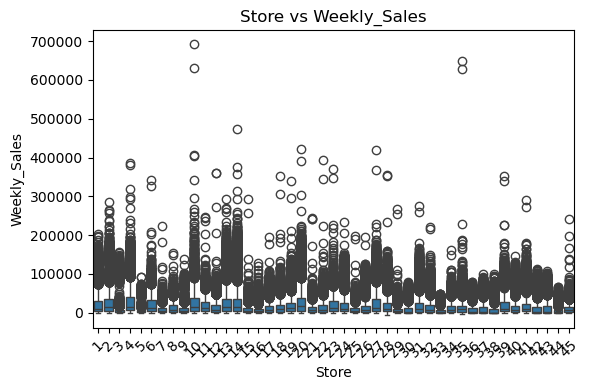

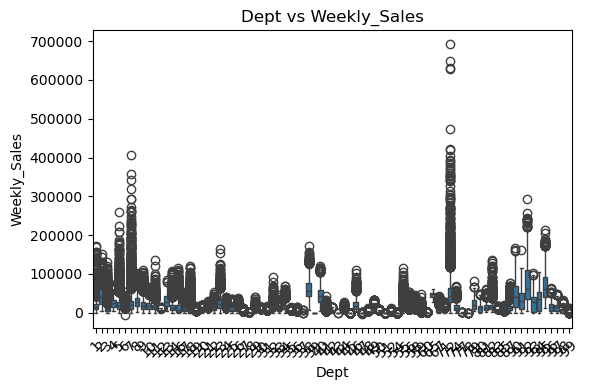

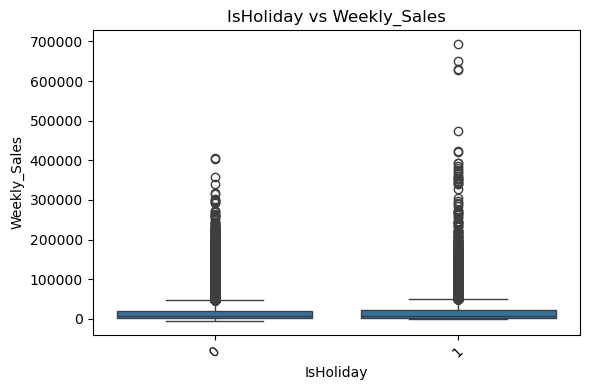

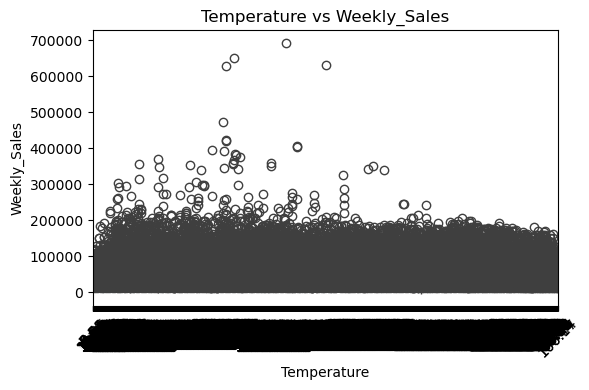

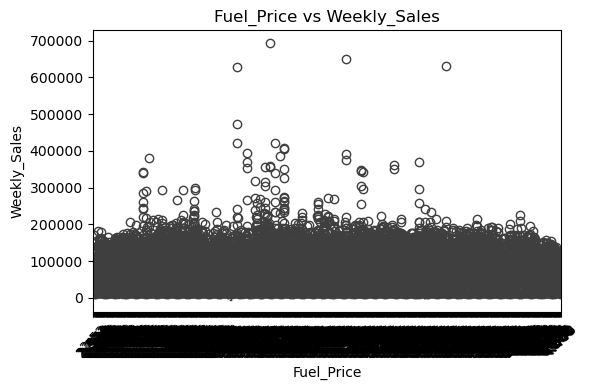

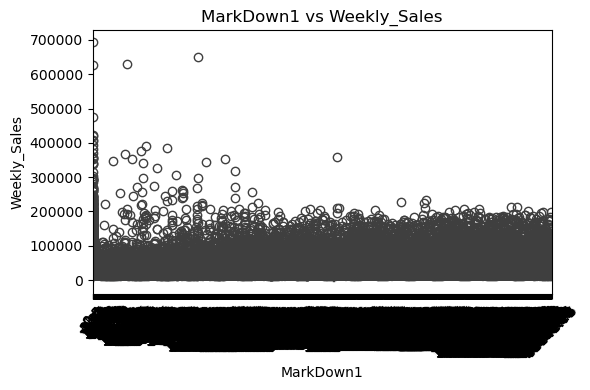

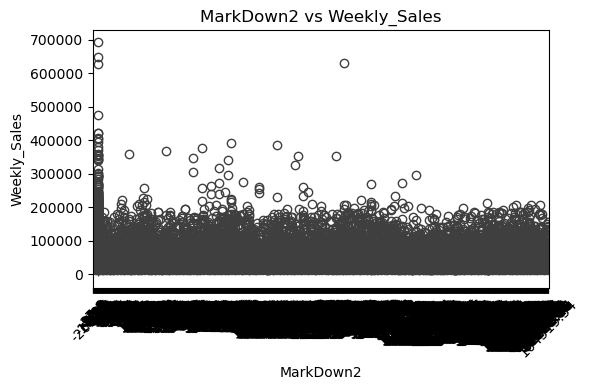

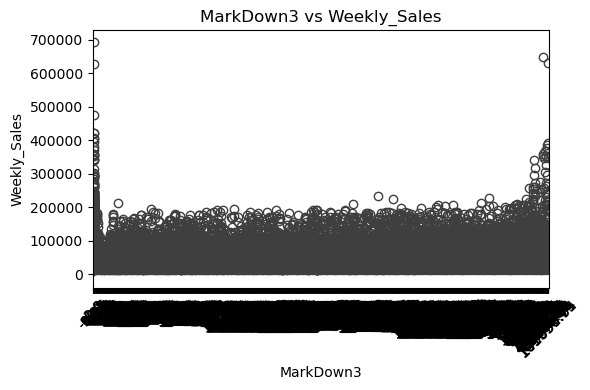

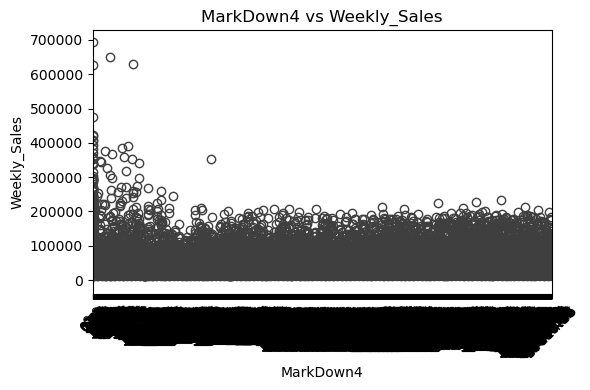

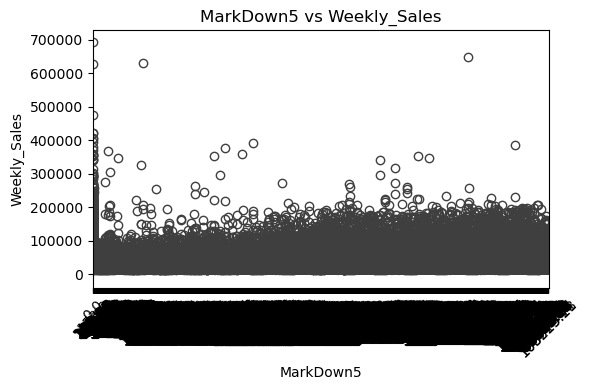

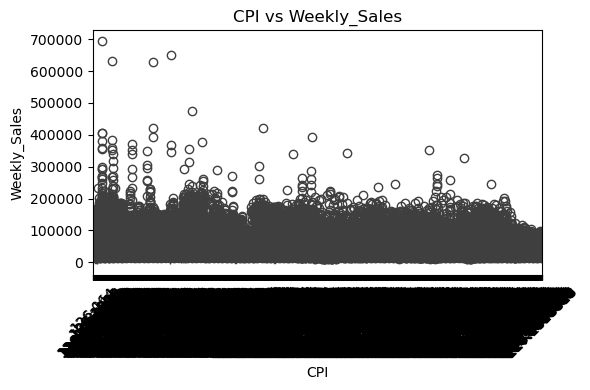

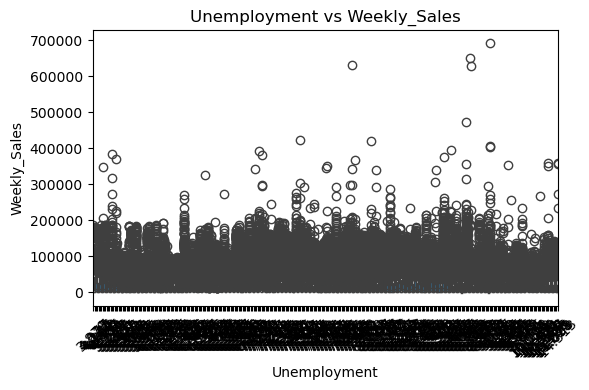

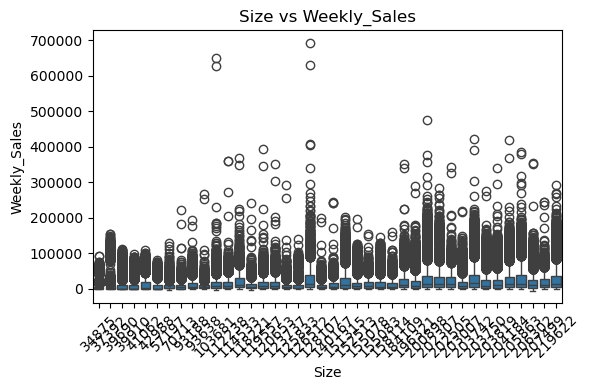

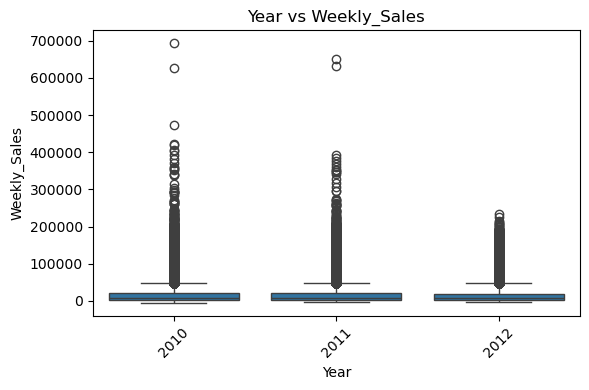

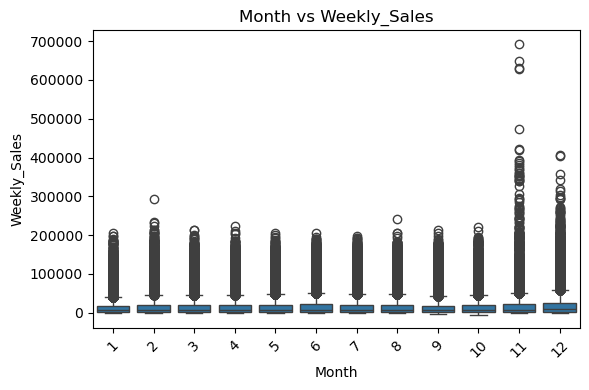

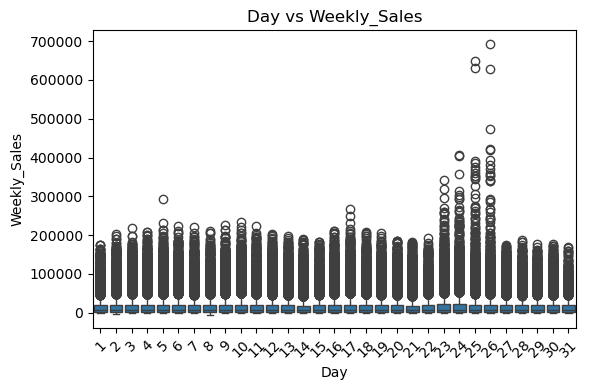

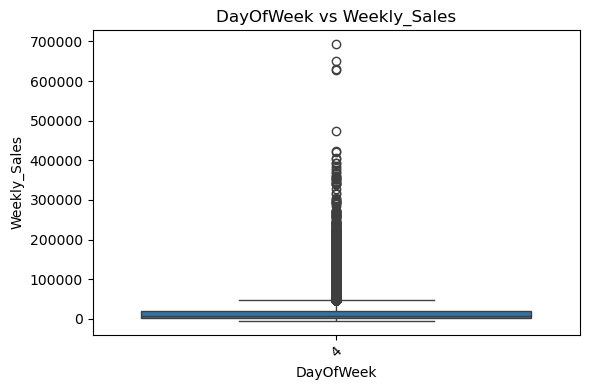

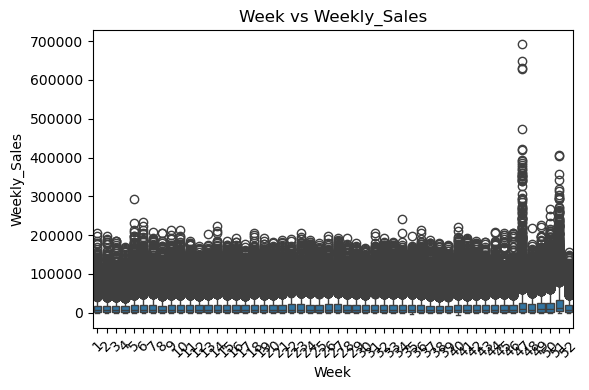

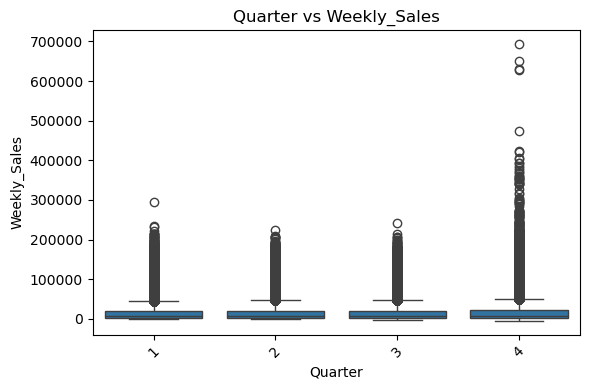

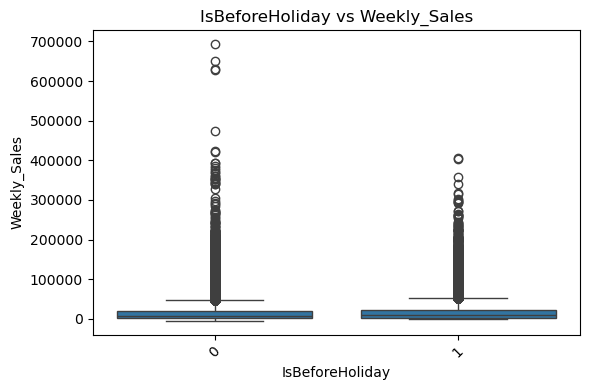

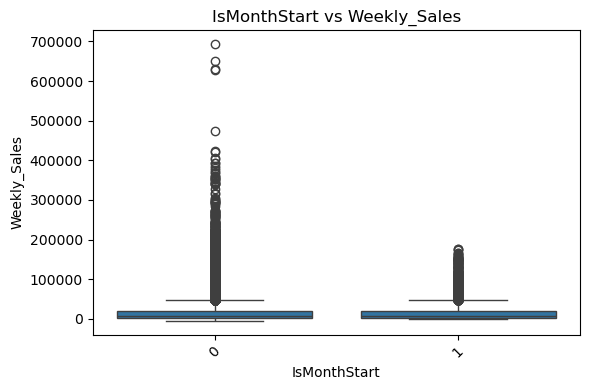

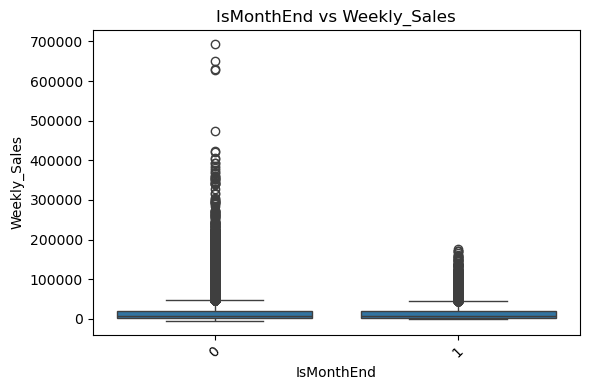

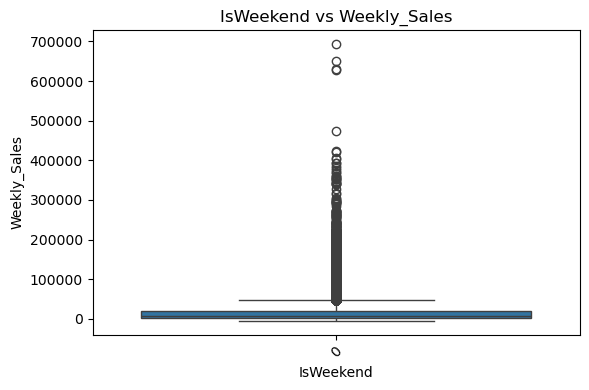

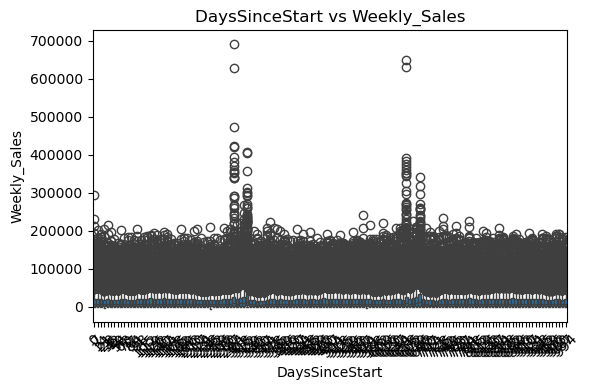

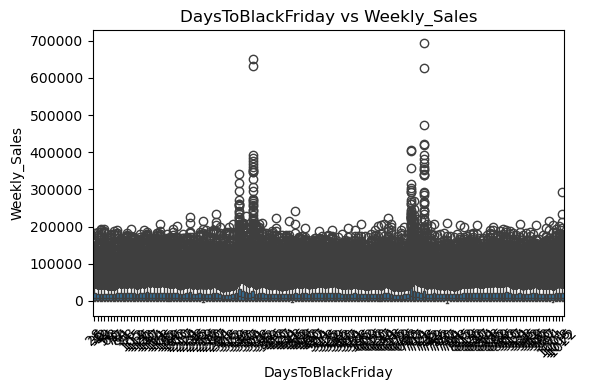

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Store,421570.0,NaN,NaN,NaN,22.200546,1.0,11.0,22.0,33.0,45.0,12.785297
Dept,421570.0,NaN,NaN,NaN,44.260317,1.0,18.0,37.0,74.0,99.0,30.492054
Date,421570,NaN,NaN,NaN,2011-06-18 08:30:31.963375104,2010-02-05 00:00:00,2010-10-08 00:00:00,2011-06-17 00:00:00,2012-02-24 00:00:00,2012-10-26 00:00:00,NaN
Weekly_Sales,421570.0,NaN,NaN,NaN,15981.258123,-4988.94,2079.65,7612.03,20205.8525,693099.36,22711.183519
IsHoliday,421570.0,NaN,NaN,NaN,0.070358,0.0,0.0,0.0,0.0,1.0,0.25575
Temperature,421570.0,NaN,NaN,NaN,60.090059,-2.06,46.68,62.09,74.28,100.14,18.447931
Fuel_Price,421570.0,NaN,NaN,NaN,3.361027,2.472,2.933,3.452,3.738,4.468,0.458515
MarkDown1,421570.0,NaN,NaN,NaN,2590.074819,0.0,0.0,0.0,2809.05,88646.76,6052.385934
MarkDown2,421570.0,NaN,NaN,NaN,879.974298,-265.76,0.0,0.0,2.2,104519.54,5084.538801
MarkDown3,421570.0,NaN,NaN,NaN,468.087665,-29.1,0.0,0.0,4.54,141630.61,5528.873453


In [12]:
check_cardinality(train)
plot_feature_vs_target(train, "Weekly_Sales")
summarize_features(train)

In [13]:
correlation_matrix = train.corr(numeric_only=True)

print("Correlation with Weekly_Sales:\n")
print(correlation_matrix["Weekly_Sales"].sort_values(ascending=False))

Correlation with Weekly_Sales:

Weekly_Sales         1.000000
Size                 0.243828
Dept                 0.148032
MarkDown5            0.050465
MarkDown1            0.047172
MarkDown3            0.038562
MarkDown4            0.037467
Month                0.028409
Week                 0.027673
Quarter              0.023838
IsBeforeHoliday      0.023696
MarkDown2            0.020716
IsHoliday            0.012774
DaysToBlackFriday    0.000663
Fuel_Price          -0.000120
DaysSinceStart      -0.000663
Temperature         -0.002312
IsMonthStart        -0.004047
Day                 -0.006187
IsMonthEnd          -0.009319
Year                -0.010111
CPI                 -0.020921
Unemployment        -0.025864
Store               -0.085195
DayOfWeek                 NaN
IsWeekend                 NaN
Name: Weekly_Sales, dtype: float64


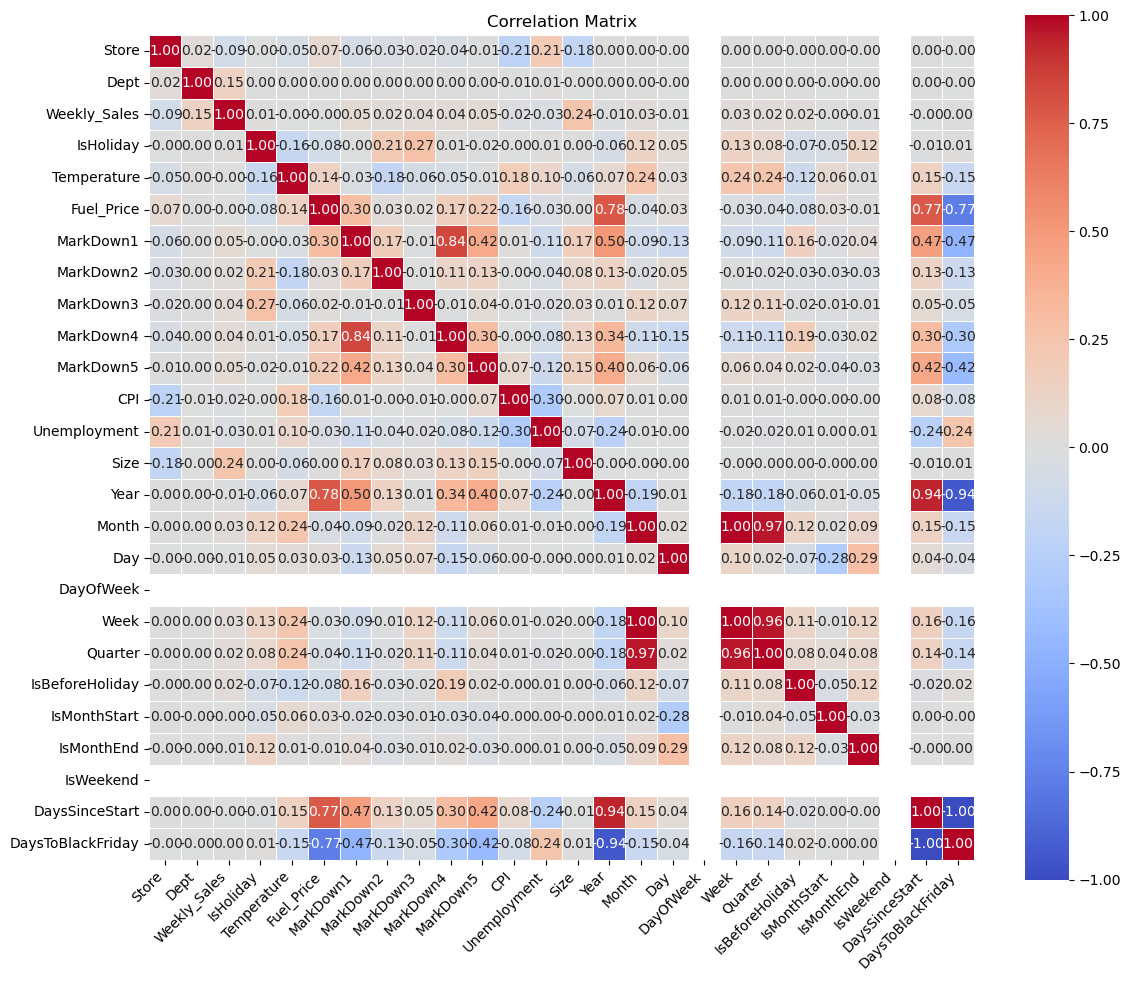

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd

selected_features = [
    "Store", "Dept", "Size", 
    "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5",
    "IsHoliday", "IsBeforeHoliday",
    "IsWeekend", "DayOfWeek",
    "Month", "Week", "Quarter", "Day",
    "DaysSinceStart"
]

X_train = train[selected_features].copy()
X_test = test[selected_features].copy()

X_test.to_csv("data/test_RandomForest.csv", index=False)

# Training

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import mlflow
import mlflow.sklearn

def train_and_log_model(model, model_name, params, X, y):
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("model_type", model_name)
        for k, v in params.items():
            mlflow.log_param(k, v)

        X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, test_size=0.2)

        model.fit(X_train, y_train)

        preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        mlflow.log_metric("MAE", mae)

        pipeline = Pipeline(steps=[("model", model)])
        registered_model_name = f"RandomForest_Walmart_{model_name}"
        mlflow.sklearn.log_model(
            pipeline,
            artifact_path=model_name,
            registered_model_name=registered_model_name
        )

In [26]:
from sklearn.ensemble import RandomForestRegressor

rf_params_variants = {
    "RandomForest_v1": {
        "n_estimators": 200,
        "max_depth": 20,
        "min_samples_split": 5,
        "min_samples_leaf": 2,
        "random_state": 42,
        "n_jobs": -1
    },
    "RandomForest_v2": {
        "n_estimators": 300,
        "max_depth": 30,
        "min_samples_split": 4,
        "min_samples_leaf": 1,
        "random_state": 42,
        "n_jobs": -1
    },
    "RandomForest_v3": {
        "n_estimators": 400,
        "max_depth": 15,
        "min_samples_split": 10,
        "min_samples_leaf": 5,
        "random_state": 42,
        "n_jobs": -1
    },
    "RandomForest_v4": {
        "n_estimators": 250,
        "max_depth": 25,
        "min_samples_split": 8,
        "min_samples_leaf": 3,
        "random_state": 42,
        "n_jobs": -1
    },
    "RandomForest_v5": {
        "n_estimators": 200,
        "max_depth": 15,
        "min_samples_split": 20,
        "min_samples_leaf": 10,
        "random_state": 42,
        "n_jobs": -1
    }
}


for model_name, params in rf_params_variants.items():
    X = X_train.copy()
    y = train.loc[X.index, "Weekly_Sales"]

    print(f"Training model: {model_name}")
    model = RandomForestRegressor(**params)
    train_and_log_model(model, model_name, params, X, y)

Training model: RandomForest_v1


2025/07/17 16:58:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RandomForest_Walmart_RandomForest_v1' already exists. Creating a new version of this model...
2025/07/17 17:01:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForest_Walmart_RandomForest_v1, version 2
Created version '2' of model 'RandomForest_Walmart_RandomForest_v1'.


🏃 View run RandomForest_v1 at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/5/runs/84b86622d36d4576bae2635d8acfc8b2
🧪 View experiment at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/5
Training model: RandomForest_v2


2025/07/17 17:02:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'RandomForest_Walmart_RandomForest_v2'.
2025/07/17 17:12:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForest_Walmart_RandomForest_v2, version 1
Created version '1' of model 'RandomForest_Walmart_RandomForest_v2'.


🏃 View run RandomForest_v2 at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/5/runs/c6a32074eef746d68ca3c8893853651b
🧪 View experiment at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/5
Training model: RandomForest_v3


2025/07/17 17:13:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'RandomForest_Walmart_RandomForest_v3'.
2025/07/17 17:16:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForest_Walmart_RandomForest_v3, version 1
Created version '1' of model 'RandomForest_Walmart_RandomForest_v3'.


🏃 View run RandomForest_v3 at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/5/runs/7020c0d206ae4306b638b05cd4a66152
🧪 View experiment at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/5
Training model: RandomForest_v4


2025/07/17 17:16:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'RandomForest_Walmart_RandomForest_v4'.
2025/07/17 17:19:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForest_Walmart_RandomForest_v4, version 1
Created version '1' of model 'RandomForest_Walmart_RandomForest_v4'.


🏃 View run RandomForest_v4 at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/5/runs/8487e0d812be4cfabdce98564017e1ab
🧪 View experiment at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/5
Training model: RandomForest_v5


2025/07/17 17:20:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'RandomForest_Walmart_RandomForest_v5'.
2025/07/17 17:20:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForest_Walmart_RandomForest_v5, version 1
Created version '1' of model 'RandomForest_Walmart_RandomForest_v5'.


🏃 View run RandomForest_v5 at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/5/runs/757a360e7f7f4e279cfb16fcd1b21cfe
🧪 View experiment at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/5
